## Composite Index of Perceived Touristic Attractiveness (IGATP)

This notebook takes three sub-indices—Bayesian-adjusted rating, popularity and sentiment—and combines them into a single **composite IGATP** score for each point of interest.

**Pipeline**

1. Load data with `Rating_Bayes`, `Total_Reviews` and raw comment polarities.  
2. Compute **average sentiment polarity** per place.  
3. **Normalize** each sub-index to [0,1].  
4. Choose weights (\($w_1$, $w_2$, $w_3$\)).  
5. Calculate

$$
\mathrm{IGATP}_i
= w_1 \times \mathrm{Rating\_Bayes}_i^{\mathrm{norm}}
+ w_2 \times \mathrm{Popularity}_i^{\mathrm{norm}}
+ w_3 \times \mathrm{Sentiment}_i^{\mathrm{norm}}
$$

6. Inspect top results and export for downstream use.

## 1. Imports & Data Loading

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load the pre-computed Bayesian ratings and raw data
ratings_bayes = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/4_bayesian_rating_adjustment/ratings_with_bayesian_adjustment.csv")
comments = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/2_pre_processing_NLP/comments_clean.csv")

print("Ratings (Bayes) shape:", ratings_bayes.shape)
print("Comments shape:", comments.shape)

Ratings (Bayes) shape: (2520, 17)
Comments shape: (9063, 14)


## 2. Compute Average Sentiment per Place

In [36]:
# Group by place name in comments and average the 'Polaridade' column
polarity = (
    comments
    .groupby("Nome_Local")["Polaridade"]
    .mean()
    .reset_index()
    .rename(columns={"Polaridade": "Avg_Polarity"})
)

print("Computed average polarity for", polarity.shape[0], "places.")


Computed average polarity for 1413 places.


In [45]:
polarity.head()

,Nome_Local,Avg_Polarity
0,"""VOLTARIA"" - Petisqueira Portuguesa",0.296687
1,(In)Fusão Comida Com História,0.628000
2,100 Montaditos Póvoa de Varzim,0.278667
3,1001 Ofertas,0.108571
4,18 St. Hostel,0.467604


## 3. Merge Sub-Indices into One DataFrame

In [37]:
# Merge Avg_Polarity into the ratings_bayes table
df = ratings_bayes.merge(
    polarity,
    left_on="Nome",        # adjust if your column is named differently
    right_on="Nome_Local",
    how="left"
)

# Check for any missing sentiment
missing_sent = df["Avg_Polarity"].isna().sum()
print(f"Places without sentiment data: {missing_sent}")

Places without sentiment data: 1713


## 4. Normalize Each Sub-Index

In [38]:
# Initialize scaler
scaler = MinMaxScaler()

# 4.1 Rating_Bayes
df["Rating_Bayes_norm"] = scaler.fit_transform(df[["Rating_Bayes"]])

# 4.2 Popularity = Total_Reviews
df["Popularity_norm"] = scaler.fit_transform(df[["Total_Reviews"]])

# 4.3 Sentiment = Avg_Polarity (fill missing with global mean first)
global_polarity = df["Avg_Polarity"].mean()
df["Avg_Polarity"].fillna(global_polarity, inplace=True)
df["Sentiment_norm"] = scaler.fit_transform(df[["Avg_Polarity"]])

# Quick sanity check
print(df[["Rating_Bayes_norm", "Popularity_norm", "Sentiment_norm"]].describe())

       Rating_Bayes_norm  Popularity_norm  Sentiment_norm
count        2520.000000      2520.000000     2520.000000
mean            0.814051         0.002222        0.654808
std             0.063876         0.024056        0.068510
min             0.000000         0.000000        0.000000
25%             0.819656         0.000000        0.654808
50%             0.819656         0.000000        0.654808
75%             0.819656         0.000000        0.654808
max             1.000000         1.000000        1.000000


C:\Users\Fernanda Costa\AppData\Local\Temp\ipykernel_18880\3921256223.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Avg_Polarity"].fillna(global_polarity, inplace=True)


## 5. Correlations

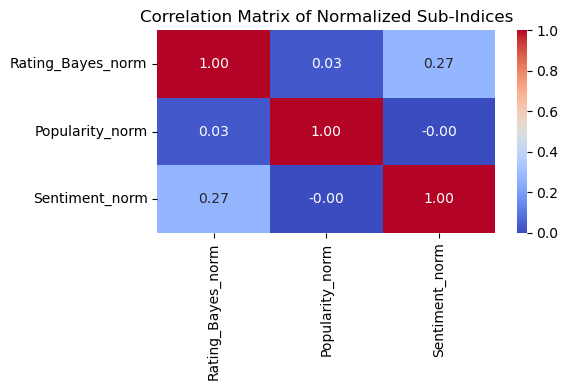

In [39]:
# Selecionar apenas os subíndices normalizados
subindices = df[["Rating_Bayes_norm", "Popularity_norm", "Sentiment_norm"]]

# Calcular a matriz de correlação
correlation_matrix = subindices.corr()

# Visualizar com um heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Normalized Sub-Indices")
plt.tight_layout()
plt.show()


## 6. Compute Composite IGATP

In [40]:
# Define weights (must sum to 1)
w1, w2, w3 = 1/3, 1/3, 1/3

df["IGATP"] = (
    w1 * df["Rating_Bayes_norm"]
  + w2 * df["Popularity_norm"]
  + w3 * df["Sentiment_norm"]
)

print(
    "IGATP computed. Range:",
    round(df["IGATP"].min(), 3),
    "to",
    round(df["IGATP"].max(), 3)
)

IGATP computed. Range: 0.095 to 0.873


## 7. Inspect Top & Export

In [41]:
# Top 10 by IGATP
top10 = df.sort_values("IGATP", ascending=False).head(10)
display(top10[[
    "id_unico", "Nome", "Rating_Bayes", "Total_Reviews",
    "Avg_Polarity", "IGATP"
]].style.format({
    "Rating_Bayes": "{:.3f}",
    "Avg_Polarity": "{:.3f}",
    "IGATP": "{:.3f}"
}))

# Export full composite index
df.to_csv("composite_index.csv", index=False)
print("Exported composite_index.csv with", df.shape[0], "rows.")

,id_unico,Nome,Rating_Bayes,Total_Reviews,Avg_Polarity,IGATP
495,40050dbe,Luís I Bridge,4.800,86331,0.356,0.873
498,d7b17b43,Jardim do Morro,4.700,30647,0.356,0.644
7,55c15277,Abadessa Restaurante e Petiscos,4.810,26,0.724,0.635
474,e297490f,Parque Nascente Shopping,4.300,39129,0.356,0.622
543,5ce416a1,La Bocca Dolce,4.858,132,0.608,0.613
534,5b643d50,Chef Mamã,4.862,150,0.593,0.609
1996,b9e67565,Restaurante Bella Vista,4.449,0,0.807,0.607
153,5395f923,Sabores da Fatinha,4.863,152,0.577,0.605
1621,0b987770,Hotel Premium,4.449,0,0.800,0.605
540,3cedfae9,DaCasa,4.784,282,0.549,0.588


Exported composite_index.csv with 2520 rows.


In [42]:
df['id_unico'].isnull().sum()

0

In [43]:
df['Avg_Polarity'].count()

2520

In [44]:
df['IGATP'].isnull().sum()

0